### Plot Error vs N

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

In [2]:
def computeCI(data_list, alpha=0.05):
    '''
    This function computes the 100*(1-alpha)% Confidence Interval for the true mean based
    on n observations given a list.
    '''
    # Convert list to numpy array
    data = np.array(data_list)
    n = len(data)
    
    # Calculate mean and standard error
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # Sample std (using Bessel's correction with ddof=1)
    se = std / np.sqrt(n)
    
    # Calculate confidence interval using t-distribution
    df = n - 1
    t_critical = stats.t.ppf(1 - alpha/2, df)
    margin = t_critical * se
    
    return mean, margin

In [3]:
ama_means = []
ama_margins = []
qbc_means = []
qbc_margins = []
feature_means = []
feature_margins = []
N = list(pd.read_csv(f'DistLogs/dist_trial{0}_log.csv')['N'])[:7]
num_trials = 10
for j in range(len(N)):
    ama_relativeOODerror = []
    qbc_relativeOODerror = []
    feature_relativeOODerror = []
    for k in range(num_trials):
        ama_df = pd.read_csv(f'DistLogs/dist_trial{k}_log.csv')
        qbc_df = pd.read_csv(f'ALLogs/QBC_trial{k}_log.csv')
        feature_df = pd.read_csv(f'ALLogs/feature_trial{k}_log.csv')
        ama_relativeOODerror.append(ama_df['Relative_OOD_Error'][j])
        qbc_relativeOODerror.append(qbc_df['Relative_OOD_Error'][j])
        feature_relativeOODerror.append(feature_df['Relative_OOD_Error'][j])
    ama_mean, ama_margin = computeCI(ama_relativeOODerror, alpha=0.05)
    qbc_mean, qbc_margin = computeCI(qbc_relativeOODerror, alpha=0.05)
    feature_mean, feature_margin = computeCI(feature_relativeOODerror, alpha=0.05)
    ama_means.append(ama_mean)
    ama_margins.append(ama_margin)
    qbc_means.append(qbc_mean)
    qbc_margins.append(qbc_margin)
    feature_means.append(feature_mean)
    feature_margins.append(feature_margin)

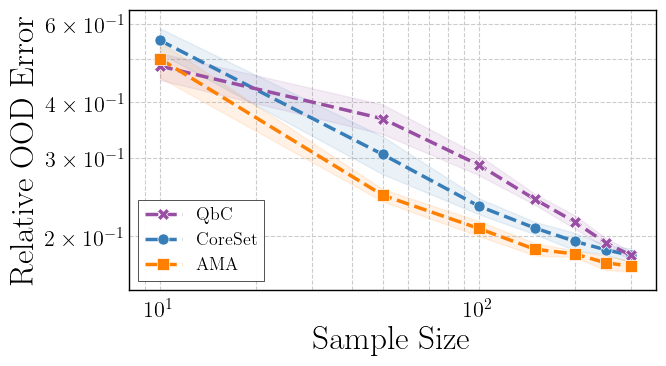

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 14
rcParams['figure.titlesize'] = 14
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.3
rcParams['axes.linewidth'] = 0.8
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = 'black'
rcParams['xtick.color'] = 'black'
rcParams['ytick.color'] = 'black'
rcParams['axes.edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(7, 4), dpi=100)

# Convert to numpy arrays for easier manipulation
N_array = np.array(N)
ama_means_array = np.array(ama_means)
ama_margins_array = np.array(ama_margins)
qbc_means_array = np.array(qbc_means)
qbc_margins_array = np.array(qbc_margins)
feature_means_array = np.array(feature_means)
feature_margins_array = np.array(feature_margins)

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#984ea3']  # Blue, Orange, Green, Purple
alphas = [0.1, 0.1, 0.1, 0.1]  # Transparency for confidence bands

# QBC Model
ax.loglog(N_array, qbc_means_array, 
          color=colors[3], linewidth=2.5,
          marker='X', markersize=8, markeredgewidth=0.5, markeredgecolor='white',
          label='QbC', zorder=3, linestyle='--')
ax.fill_between(N_array, 
                 qbc_means_array - qbc_margins_array,
                 qbc_means_array + qbc_margins_array,
                 color=colors[3], alpha=alphas[3], zorder=1)

# Feature
ax.loglog(N_array, feature_means_array, 
          color=colors[0], linewidth=2.5, 
          marker='o', markersize=8, markeredgewidth=0.5, markeredgecolor='white',
          label='CoreSet', zorder=2, linestyle='--')
ax.fill_between(N_array, 
                 feature_means_array - feature_margins_array,
                 feature_means_array + feature_margins_array,
                 color=colors[0], alpha=alphas[0], zorder=1)

# AMA Model
ax.loglog(N_array, ama_means_array, 
          color=colors[1], linewidth=2.5,
          marker='s', markersize=9, markeredgewidth=0.5, markeredgecolor='white',
          label='AMA', zorder=3, linestyle='--')
ax.fill_between(N_array, 
                 ama_means_array - ama_margins_array,
                 ama_means_array + ama_margins_array,
                 color=colors[1], alpha=alphas[1], zorder=1)

ax.set_xlabel('Sample Size', fontweight='medium')
ax.set_ylabel('Relative OOD Error', fontweight='medium')

# Set y-axis limits with some padding (fixed the min/max calculation)
all_lower_bounds = np.concatenate([
    ama_means_array - ama_margins_array,
    qbc_means_array - qbc_margins_array,
    feature_means_array - feature_margins_array
])
all_upper_bounds = np.concatenate([
    ama_means_array + ama_margins_array,
    qbc_means_array + qbc_margins_array,
    feature_means_array + feature_margins_array
])

y_min = np.min(all_lower_bounds)
y_max = np.max(all_upper_bounds)
y_padding_factor = 1.1  # For log scale, use multiplicative padding
ax.set_ylim(y_min / y_padding_factor, y_max * y_padding_factor)

# Set x-axis limits with padding
ax.set_xlim(N[0] * 0.8, N[-1] * 1.2)

legend = ax.legend(loc='lower left', 
                   frameon=True, 
                   fancybox=False, 
                   shadow=False,
                   framealpha=0.95,
                   edgecolor='black',
                   ncol=1,
                   fontsize=13)
legend.get_frame().set_linewidth(0.5)

ax.grid(True, alpha=1, linestyle='--', which='both')  # Grid for both major and minor ticks
ax.spines['left'].set_edgecolor('black')
ax.set_axisbelow(True)

ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)
ax.spines['top'].set_linewidth(1)
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_edgecolor('black')
ax.spines['right'].set_edgecolor('black')
ax.spines['top'].set_edgecolor('black')

# Get space between x axis exponents and x axis
ax.tick_params(axis='x', pad=8)

plt.tight_layout()

# Save the figure in high resolution
# Uncomment the following line to save the figure
# plt.savefig(f'Images/burgers_comparison_300samples.png', dpi=300, bbox_inches='tight')

plt.show()

### Plot input output

In [5]:
import scipy.io
import math

In [6]:
data = scipy.io.loadmat('burgers_data_R10.mat')
n = data['a'].shape[1]

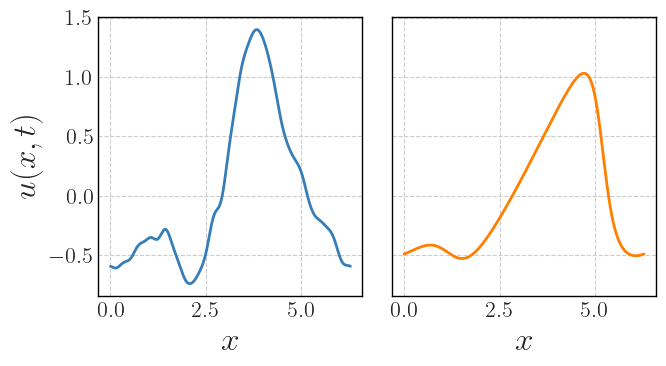

In [7]:
# compact style close to your original
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'font.size': 18,
    'axes.labelsize': 24,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'grid.alpha': 0.3,
    'axes.linewidth': 0.8,
})

# data
sample = 13
x = np.linspace(0, 2*math.pi, n+1)[:-1]
u0 = data['a'][sample]        # initial condition u(x,0)
u_T = data['u'][sample]     # replace with your T=1 solution array

colors = ['#377eb8', '#ff7f00']

# side-by-side comparison (recommended)
fig, axes = plt.subplots(1, 2, figsize=(7, 4), dpi=100, sharey=True)
axes[0].plot(x, u0, color=colors[0], linewidth=2)
# axes[0].set_title(r'Initial condition: $u(x,0)$')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$u(x,t)$')   # shared y-label

axes[1].plot(x, u_T, color=colors[1], linewidth=2)
# axes[1].set_title(r'Solution at $T=1$: $u(x,1)$')
axes[1].set_xlabel(r'$x$')

axes[0].grid(True, alpha=1, linestyle='--', which='both')  # Grid for both major and minor ticks
axes[0].spines['left'].set_edgecolor('black')
axes[0].set_axisbelow(True)
axes[0].spines['left'].set_linewidth(1)
axes[0].spines['bottom'].set_linewidth(1)
axes[0].spines['right'].set_linewidth(1)
axes[0].spines['top'].set_linewidth(1)
axes[0].spines['left'].set_edgecolor('black')
axes[0].spines['bottom'].set_edgecolor('black')
axes[0].spines['right'].set_edgecolor('black')
axes[0].spines['top'].set_edgecolor('black')

axes[1].grid(True, alpha=1, linestyle='--', which='both')  # Grid for both major and minor ticks
axes[1].spines['left'].set_edgecolor('black')
axes[1].set_axisbelow(True)
axes[1].spines['left'].set_linewidth(1)
axes[1].spines['bottom'].set_linewidth(1)
axes[1].spines['right'].set_linewidth(1)
axes[1].spines['top'].set_linewidth(1)
axes[1].spines['left'].set_edgecolor('black')
axes[1].spines['bottom'].set_edgecolor('black')
axes[1].spines['right'].set_edgecolor('black')
axes[1].spines['top'].set_edgecolor('black')

plt.tight_layout()

# plt.savefig(f'Images/burgers_io.png', dpi=300, bbox_inches='tight')

plt.show()